<a href="https://colab.research.google.com/github/OlegLaiok/Comp_Lingv/blob/homework5-6/%D0%BB%D0%B0%D0%B1%D0%B0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pymorphy2
!pip install nltk

In [29]:
import json
from math import nan
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Мы взяли датасет (https://www.kaggle.com/vfomenko/russian-news-2020) текстов новостей за 2020 год разбитых по категориям (в датасете они идут в поле 'rubric'). В данной работе мы проанализируем, как точно программа будет распределять текста в эти катигории.

In [31]:
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news.csv')
print(news.head())

     source                                           title  ...     subrubric tags
0  lenta.ru                                  Синий богатырь  ...  Госэкономика  NaN
1  lenta.ru  Загитова согласилась вести «Ледниковый период»  ...   Зимние виды  NaN
2  lenta.ru       Объяснена опасность однообразного питания  ...           Еда  NaN
3  lenta.ru                      «Предохраняться? А зачем?»  ...    ТВ и радио  NaN
4  lenta.ru     Ефремов систематически употреблял наркотики  ...          Кино  NaN

[5 rows x 7 columns]


In [32]:
data = pd.DataFrame(news.loc[0:2000, ['text', 'rubric']]) #Всего в датасете более 20 тыс. записей, но для задания нам хватит и 2 тыс.

In [33]:
for i in range(len(data['rubric'])): # Описываем поля в который значение равно null
    if (isinstance(data['rubric'][i], str)):
        pass
    else:
        data['rubric'][i] = 'Nothing'
news_text = data['text'].to_list()
punct = string.punctuation + "—" + "«" + "»"
stopwords_list = stopwords.words("russian")
stopwords_list.append(stopwords.words('english'))
analyzer = pymorphy2.MorphAnalyzer()

In [34]:
for i in range(0,len(news_text)):
    news_text[i]= re.sub(r'\n', ' ', news_text[i]) #удаляем символы новой строки
    news_text[i]= re.sub(r'\bhttp.+\b', ' ', news_text[i]) #удаляем ссылки
    news_text[i] = re.sub(r'\s{2,}'," ",news_text[i]) #удаляем образовавшиеся повторы пробелов
    news_text[i] = word_tokenize(news_text[i]) #токенизируем текст
    news_text[i] = [token.lower() for token in news_text[i] if token not in punct] #приводим к нижнему регистру и удаляем пунктуацию
    news_text[i] = [word for word in news_text[i] if word not in stopwords_list] #удаляем стоп слова
    news_text[i] = [analyzer.parse(word)[0].normal_form for word in news_text[i]] #лемматизируем токены
news_text = [' '.join(text) for text in news_text] #приводим токены в формат string для обработки модулем CountVectorizer

In [35]:
x_train, x_test, y_train, y_test = train_test_split(news_text, data.rubric, train_size = 0.5) #разделяем данные на тренировочную и текстовую выборку. x - данные текстов, y - рубрики
table = {'type': [], 'settings': [], 'precision': [], 'recall': [],
              'accuracy': [], 'f_1': []} #задаем табличку для хранения данных о точности метрик для каждого типа векторизации

In [36]:
#векторизация из sklearn по n-граммам различного порядка
for n in range(1,10):
    vectorizer = CountVectorizer(ngram_range=(1, n), stop_words=stopwords.words("russian"))
    vectorized_x_train = vectorizer.fit_transform(x_train) #обучаем векторайзер на тренировочной выборке
    clf = MultinomialNB() #выбираем модель Байесовского классификатора
    clf.fit(vectorized_x_train, y_train) #обучаем классификатор
    vectorized_x_test = vectorizer.transform(x_test) #применяем векторайзер на данных
    pred = clf.predict(vectorized_x_test) #получаем прогнозируемые данные согласно обученному классификатору
    print('При n=',n)
    print(classification_report(y_test, pred)) #получаем отчет о полученных данных
    #записываем метрики в таблицу
    table['type'].append('n-grams')
    table['settings'].append(f'(1, {n})')
    table['precision'].append(precision_score(y_test, pred, zero_division=1, average='macro'))
    table['recall'].append(recall_score(y_test, pred,zero_division=1, average='macro'))
    table['accuracy'].append(accuracy_score(y_test, pred))
    table['f_1'].append(f1_score(y_test, pred, zero_division=1, average='macro'))

При n= 1
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.75      0.88      0.81       121
              Дом       0.83      0.19      0.31        26
         Из жизни       0.80      0.38      0.52        42
   Интернет и СМИ       0.46      0.60      0.52        45
         Культура       0.76      0.42      0.54        45
              Мир       0.60      0.85      0.70       158
  Наука и техника       0.95      0.51      0.67        37
       Нацпроекты       1.00      0.39      0.56        23
      Путешествия       1.00      0.57      0.73        42
           Россия       0.65      0.72      0.69       166
Силовые структуры       0.73      0.61      0.67        54
            Спорт       0.99      0.92      0.95       122
         Ценности       0.94      0.69      0.79        45
        Экономика       0.65      0.86      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.85      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       1.00      0.17      0.29        42
   Интернет и СМИ       0.50      0.38      0.43        45
         Культура       0.69      0.24      0.36        45
              Мир       0.47      0.85      0.61       158
  Наука и техника       0.92      0.30      0.45        37
       Нацпроекты       1.00      0.43      0.61        23
      Путешествия       1.00      0.33      0.50        42
           Россия       0.55      0.78      0.64       166
Силовые структуры       0.85      0.43      0.57        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.69      0.82      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.75      0.84      0.79       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.47      0.36      0.41        45
         Культура       0.69      0.24      0.36        45
              Мир       0.45      0.85      0.59       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.43      0.61        23
      Путешествия       1.00      0.29      0.44        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.82      0.33      0.47        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.69      0.78      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.84      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.46      0.38      0.41        45
         Культура       0.67      0.22      0.33        45
              Мир       0.45      0.84      0.58       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.48      0.65        23
      Путешествия       1.00      0.29      0.44        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.81      0.31      0.45        54
            Спорт       1.00      0.88      0.93       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.69      0.78      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.84      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.47      0.38      0.42        45
         Культура       0.67      0.22      0.33        45
              Мир       0.43      0.82      0.57       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.57      0.72        23
      Путешествия       1.00      0.29      0.44        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.81      0.31      0.45        54
            Спорт       1.00      0.88      0.93       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.70      0.75      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.85      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.47      0.38      0.42        45
         Культура       0.67      0.22      0.33        45
              Мир       0.44      0.82      0.57       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.57      0.72        23
      Путешествия       1.00      0.31      0.47        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.85      0.31      0.46        54
            Спорт       1.00      0.88      0.93       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.70      0.75      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.85      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.47      0.38      0.42        45
         Культура       0.67      0.22      0.33        45
              Мир       0.44      0.82      0.57       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.57      0.72        23
      Путешествия       1.00      0.31      0.47        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.85      0.31      0.46        54
            Спорт       1.00      0.88      0.93       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.70      0.75      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.84      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.46      0.36      0.40        45
         Культура       0.67      0.22      0.33        45
              Мир       0.43      0.82      0.56       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.57      0.72        23
      Путешествия       1.00      0.31      0.47        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.85      0.31      0.46        54
            Спорт       1.00      0.88      0.93       122
         Ценности       0.97      0.64      0.77        45
        Экономика       0.72      0.75      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.76      0.84      0.80       121
              Дом       1.00      0.12      0.21        26
         Из жизни       0.88      0.17      0.28        42
   Интернет и СМИ       0.46      0.36      0.40        45
         Культура       0.67      0.22      0.33        45
              Мир       0.43      0.82      0.56       158
  Наука и техника       0.91      0.27      0.42        37
       Нацпроекты       1.00      0.57      0.72        23
      Путешествия       1.00      0.31      0.47        42
           Россия       0.53      0.75      0.62       166
Силовые структуры       0.85      0.31      0.46        54
            Спорт       1.00      0.88      0.93       122
         Ценности       0.97      0.62      0.76        45
        Экономика       0.73      0.75      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# векторизация по символьным n-граммам
for n in range(3,11):
    char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, n))
    char_vectorized_x_train = char_vectorizer.fit_transform(x_train)
    clf = MultinomialNB()
    clf.fit(char_vectorized_x_train, y_train)
    char_vectorized_x_test = char_vectorizer.transform(x_test)
    pred = clf.predict(char_vectorized_x_test)
    print('При n=',n)
    print(classification_report(y_test, pred))
    table['type'].append('symbol_n-grams')
    table['settings'].append(f'(3, {n})')
    table['precision'].append(precision_score(y_test, pred,zero_division=1, average='macro'))
    table['recall'].append(recall_score(y_test, pred,zero_division=1, average='macro'))
    table['accuracy'].append(accuracy_score(y_test, pred))
    table['f_1'].append(f1_score(y_test, pred,zero_division=1, average='macro'))

При n= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.87      0.83       121
              Дом       1.00      0.19      0.32        26
         Из жизни       0.76      0.31      0.44        42
   Интернет и СМИ       0.34      0.47      0.40        45
         Культура       0.71      0.38      0.49        45
              Мир       0.62      0.82      0.70       158
  Наука и техника       0.85      0.59      0.70        37
       Нацпроекты       1.00      0.35      0.52        23
      Путешествия       0.96      0.57      0.72        42
           Россия       0.51      0.70      0.59       166
Силовые структуры       0.75      0.56      0.64        54
            Спорт       0.99      0.88      0.93       122
         Ценности       0.93      0.60      0.73        45
        Экономика       0.69      0.82      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.88      0.84       121
              Дом       1.00      0.04      0.07        26
         Из жизни       1.00      0.12      0.21        42
   Интернет и СМИ       0.36      0.42      0.39        45
         Культура       0.69      0.20      0.31        45
              Мир       0.53      0.85      0.65       158
  Наука и техника       0.88      0.38      0.53        37
       Нацпроекты       1.00      0.22      0.36        23
      Путешествия       1.00      0.26      0.42        42
           Россия       0.49      0.78      0.60       166
Силовые структуры       0.79      0.35      0.49        54
            Спорт       1.00      0.87      0.93       122
         Ценности       0.96      0.53      0.69        45
        Экономика       0.64      0.81      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.88      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.39      0.33      0.36        45
         Культура       0.56      0.11      0.19        45
              Мир       0.45      0.85      0.59       158
  Наука и техника       0.88      0.19      0.31        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.14      0.25        42
           Россия       0.46      0.78      0.58       166
Силовые структуры       0.80      0.07      0.14        54
            Спорт       1.00      0.86      0.93       122
         Ценности       1.00      0.51      0.68        45
        Экономика       0.64      0.79      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.87      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.41      0.27      0.32        45
         Культура       0.62      0.11      0.19        45
              Мир       0.40      0.86      0.55       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.10      0.17        42
           Россия       0.47      0.78      0.59       166
Силовые структуры       0.80      0.07      0.14        54
            Спорт       1.00      0.80      0.89       122
         Ценности       1.00      0.49      0.66        45
        Экономика       0.64      0.75      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.85      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.60      0.20      0.30        45
         Культура       0.50      0.07      0.12        45
              Мир       0.37      0.86      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.46      0.77      0.57       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.75      0.86       122
         Ценности       1.00      0.49      0.66        45
        Экономика       0.68      0.71      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.86      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.60      0.13      0.22        45
         Культура       0.62      0.11      0.19        45
              Мир       0.35      0.87      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.47      0.77      0.59       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.74      0.85       122
         Ценности       1.00      0.44      0.62        45
        Экономика       0.70      0.64      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.85      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.71      0.11      0.19        45
         Культура       0.56      0.11      0.19        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.48      0.75      0.58       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.73      0.84       122
         Ценности       1.00      0.42      0.59        45
        Экономика       0.74      0.64      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 10
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.79      0.85      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.71      0.11      0.19        45
         Культура       0.50      0.11      0.18        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.22      0.36        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.49      0.75      0.59       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.71      0.83       122
         Ценности       1.00      0.42      0.59        45
        Экономика       0.73      0.60      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# инициализируем векторизатор TF-IDF
for n in range(1,10):
    for m_df in [0.95, 0.90, 0.85, 0.80, 0.75]:
        for mn_dif in[2,3,4]:
            tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, n), max_df=m_df, min_df=mn_dif, stop_words=stopwords.words('russian'))
            tfidf_vectorized_x_train = tfidf_vectorizer.fit_transform(x_train)
            clf = MultinomialNB()
            clf.fit(tfidf_vectorized_x_train, y_train)
            tfidf_vectorized_x_test = tfidf_vectorizer.transform(x_test)
            pred = clf.predict(tfidf_vectorized_x_test)
            print('При n=',n, ', max_dif=', m_df,', min_dif=', mn_dif)
            print(classification_report(y_test, pred))
            table['type'].append('TF-IDF')
            table['settings'].append(f'(1, {n}), {m_df}, {mn_dif}')
            table['precision'].append(precision_score(y_test, pred,zero_division=1, average='macro'))
            table['recall'].append(recall_score(y_test, pred, zero_division=1, average='macro'))
            table['accuracy'].append(accuracy_score(y_test, pred))
            table['f_1'].append(f1_score(y_test, pred,zero_division=1, average='macro'))

При n= 1 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.56      0.11      0.19        45
              Мир       0.34      0.86      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.04      0.07        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.44      0.62        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.51       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.54       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.80      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.60      0.20      0.30        45
              Мир       0.39      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.42      0.79      0.55       166
Силовые структуры       1.00      0.17      0.29        54
            Спорт       1.00      0.92      0.96       122
         Ценности       0.96      0.56      0.70        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.56      0.11      0.19        45
              Мир       0.34      0.86      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.04      0.07        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.44      0.62        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.51       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.54       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.80      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.60      0.20      0.30        45
              Мир       0.39      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.42      0.79      0.55       166
Силовые структуры       1.00      0.17      0.29        54
            Спорт       1.00      0.92      0.96       122
         Ценности       0.96      0.56      0.70        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.56      0.11      0.19        45
              Мир       0.34      0.86      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.04      0.07        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.44      0.62        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.51       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.54       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.80      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.60      0.20      0.30        45
              Мир       0.39      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.42      0.79      0.55       166
Силовые структуры       1.00      0.17      0.29        54
            Спорт       1.00      0.92      0.96       122
         Ценности       0.96      0.56      0.70        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.56      0.11      0.19        45
              Мир       0.34      0.86      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.04      0.07        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.44      0.62        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.51       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.54       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.80      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.60      0.20      0.30        45
              Мир       0.39      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.42      0.79      0.55       166
Силовые структуры       1.00      0.17      0.29        54
            Спорт       1.00      0.92      0.96       122
         Ценности       0.96      0.56      0.70        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.56      0.11      0.19        45
              Мир       0.34      0.86      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.04      0.07        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.44      0.62        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.51       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.54       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 1 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.80      0.83      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.60      0.20      0.30        45
              Мир       0.39      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.42      0.79      0.55       166
Силовые структуры       1.00      0.17      0.29        54
            Спорт       1.00      0.92      0.96       122
         Ценности       0.96      0.56      0.70        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.80      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.33      0.85      0.47       158
  Наука и техника       0.80      0.11      0.19        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.06      0.11        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.40      0.57        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.83      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.85      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.49      0.65        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.04      0.08        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.77      0.54       166
Силовые структуры       0.92      0.20      0.33        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.80      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.33      0.85      0.47       158
  Наука и техника       0.80      0.11      0.19        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.06      0.11        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.40      0.57        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.83      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.85      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.49      0.65        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.04      0.08        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.77      0.54       166
Силовые структуры       0.92      0.20      0.33        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.80      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.33      0.85      0.47       158
  Наука и техника       0.80      0.11      0.19        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.06      0.11        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.40      0.57        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.83      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.85      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.49      0.65        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.04      0.08        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.77      0.54       166
Силовые структуры       0.92      0.20      0.33        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.80      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.33      0.85      0.47       158
  Наука и техника       0.80      0.11      0.19        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.06      0.11        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.40      0.57        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.83      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.85      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.49      0.65        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.04      0.08        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.77      0.54       166
Силовые структуры       0.92      0.20      0.33        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.80      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.33      0.85      0.47       158
  Наука и техника       0.80      0.11      0.19        37
       Нацпроекты       0.00      0.00      0.00        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.76      0.54       166
Силовые структуры       1.00      0.06      0.11        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.40      0.57        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.83      0.83       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.85      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       1.00      0.11      0.20        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.49      0.65        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 2 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.82      0.82       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.85      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.04      0.08        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.77      0.54       166
Силовые структуры       0.92      0.20      0.33        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.78      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.47       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.86      0.93       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.86      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.56       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.80      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       0.92      0.22      0.36        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.78      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.47       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.86      0.93       122
         Ценности       1.00      0.38      0.55        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.86      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.56       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.80      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       0.92      0.22      0.36        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.78      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.47       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.86      0.93       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.86      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.56       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.80      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       0.92      0.22      0.36        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.78      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.47       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.86      0.93       122
         Ценности       1.00      0.38      0.55        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.86      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.56       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.80      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       0.92      0.22      0.36        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.78      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.47       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.67      0.04      0.07        54
            Спорт       1.00      0.86      0.93       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.35      0.86      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.56       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.89      0.94       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 3 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.80      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.85      0.53       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.42      0.78      0.55       166
Силовые структуры       0.92      0.22      0.36        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.35      0.87      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.88      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.83      0.19      0.30        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.35      0.87      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.88      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.83      0.19      0.30        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.35      0.87      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.88      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.83      0.19      0.30        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.35      0.87      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.88      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.83      0.19      0.30        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.35      0.87      0.50       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.44      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.88      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 4 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.38      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.09      0.16        23
      Путешествия       1.00      0.07      0.13        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.83      0.19      0.30        54
            Спорт       1.00      0.91      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.58      0.16      0.25        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.38      0.55        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.57      0.18      0.27        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 5 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.82      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.36      0.52        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.36      0.52        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.36      0.52        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.36      0.52        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.85      0.92       122
         Ценности       1.00      0.36      0.52        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 6 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.86      0.16      0.27        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.55       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 7 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.55       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.90      0.95       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.77      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.49       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 8 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.17      0.30        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.95 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.95 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.95 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.9 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.9 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.9 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.85 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.85 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.85 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.8 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.8 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.8 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.75 , min_dif= 2
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.33      0.87      0.48       158
  Наука и техника       0.75      0.08      0.15        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.43      0.78      0.56       166
Силовые структуры       0.75      0.06      0.10        54
            Спорт       1.00      0.84      0.92       122
         Ценности       1.00      0.33      0.50        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.75 , min_dif= 3
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.84      0.76      0.80       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.02      0.05        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.62      0.18      0.28        45
              Мир       0.34      0.87      0.48       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.26      0.41        23
      Путешествия       1.00      0.02      0.05        42
           Россия       0.45      0.78      0.57       166
Силовые структуры       1.00      0.13      0.23        54
            Спорт       1.00      0.87      0.93       122
         Ценности       1.00      0.49      0.66        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При n= 9 , max_dif= 0.75 , min_dif= 4
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         2
          Nothing       0.00      0.00      0.00         1
      Бывший СССР       0.83      0.79      0.81       121
              Дом       0.00      0.00      0.00        26
         Из жизни       1.00      0.05      0.09        42
   Интернет и СМИ       0.00      0.00      0.00        45
         Культура       0.54      0.16      0.24        45
              Мир       0.37      0.87      0.52       158
  Наука и техника       0.83      0.14      0.23        37
       Нацпроекты       1.00      0.13      0.23        23
      Путешествия       1.00      0.05      0.09        42
           Россия       0.43      0.77      0.56       166
Силовые структуры       0.82      0.17      0.28        54
            Спорт       1.00      0.89      0.94       122
         Ценности       0.96      0.53      0.69        45
        Экономика

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
with open("table.json", "w", encoding='utf-8') as f:
    json.dump(table, f, ensure_ascii=False)
f.close()

        type         settings  precision    recall  accuracy       f_1
0    n-grams           (1, 1)   0.816146  0.510765  0.693307  0.547162
1    n-grams           (1, 2)   0.820612  0.413666  0.619381  0.446767
2    n-grams           (1, 3)   0.819847  0.419302  0.618382  0.450756
3    n-grams           (1, 4)   0.825096  0.419592  0.618382  0.452353
4    n-grams           (1, 5)   0.826588  0.409967  0.611389  0.440890
..       ...              ...        ...       ...       ...       ...
147   TF-IDF   (1, 9), 0.8, 3   0.859561  0.307234  0.534466  0.321399
148   TF-IDF   (1, 9), 0.8, 4   0.861769  0.318546  0.550450  0.332195
149   TF-IDF  (1, 9), 0.75, 2   0.873825  0.293458  0.520480  0.307967
150   TF-IDF  (1, 9), 0.75, 3   0.859561  0.307234  0.534466  0.321399
151   TF-IDF  (1, 9), 0.75, 4   0.861769  0.318546  0.550450  0.332195

[152 rows x 6 columns]
n_grams_table:
      type settings  precision    recall  accuracy       f_1
0  n-grams   (1, 1)   0.816146  0.510765  0.6933

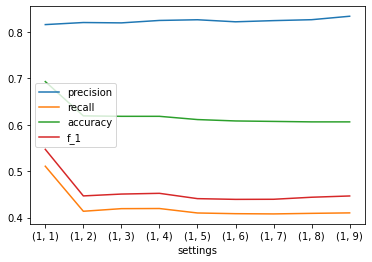

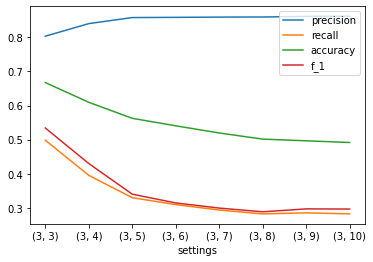

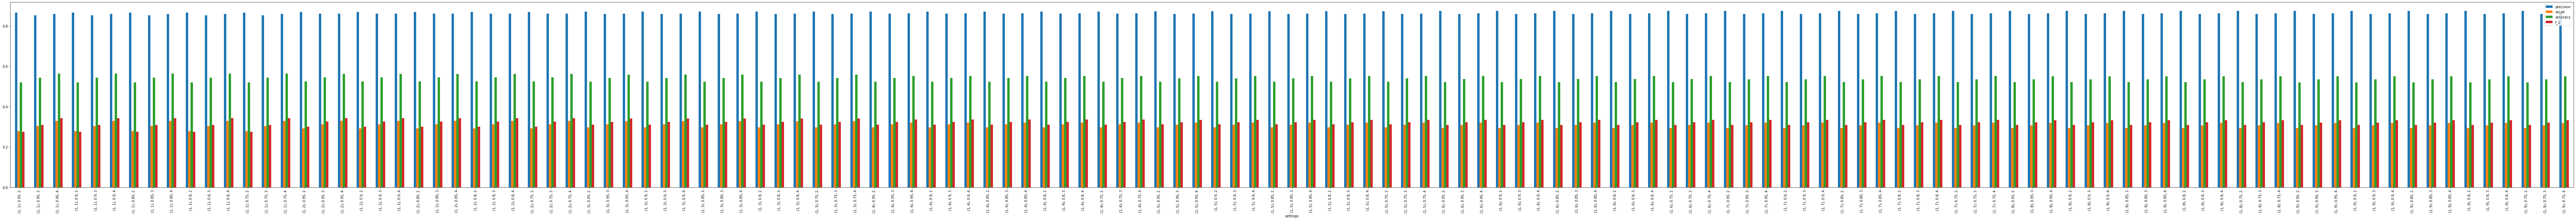

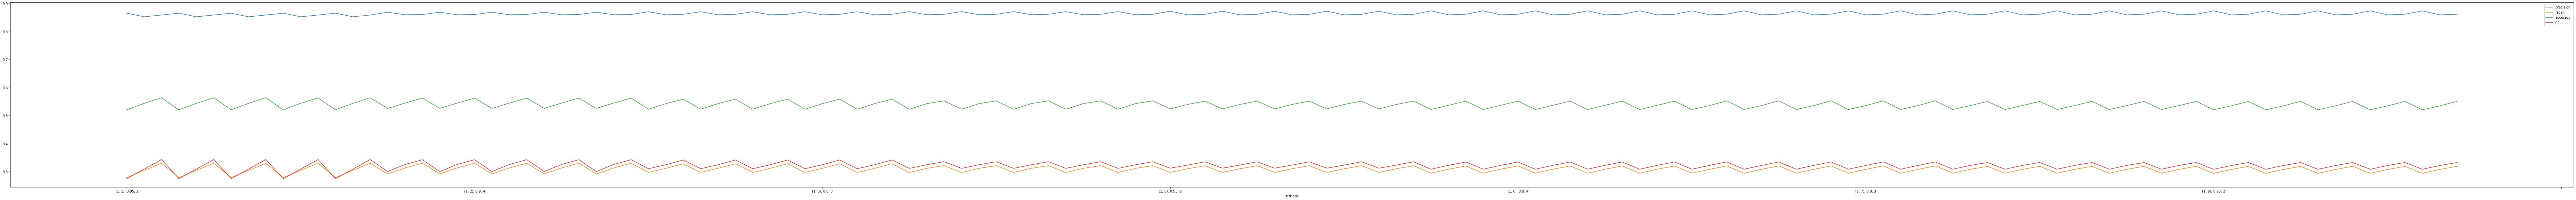

In [74]:
with open("table.json", "r", encoding ='utf-8') as f:
    table = json.load(f)
table = pd.DataFrame.from_dict(table)
print(table)
print('n_grams_table:')
n_grams = table.loc[(table['type']=='n-grams')]
print(n_grams)
print(n_grams.plot(x = 'settings'))

print('symbol n-grams table:')
symbol_ngrams = table.loc[(table['type']=='symbol_n-grams')]
print(symbol_ngrams)
print(symbol_ngrams.plot(x = 'settings'))

print('TF-IDF table:')
tf_idf = table.loc[(table['type']=='TF-IDF')]
print(tf_idf)
print(tf_idf.plot(x = 'settings', kind = 'bar', figsize = (135,10)))

print('sorted by precision')
print(table.sort_values(by='precision', ascending=False)[:3])

print('sorted by recall')
print(table.sort_values(by='recall',ascending=False)[:3])

print('sorted by accuracy')
print(table.sort_values(by='accuracy',ascending=False)[:3])

print('sorted by f_1')
print(table.sort_values(by='f_1',ascending=False)[:3])


Проанализировав полученные графики и таблицы можем сделать следующие выводы:

1.  При использовании векторайзера по n-граммам при n=5 все метрики кроме precision будут минимальными, а максимальными при n=1. Precision будет увеличиваться прямо пропорционально n.
2. При использовании векторайзера посимвольным n-граммам при n=8 все метрики кроме precision будут минимальными, а максимальными при n=3. Precision будет увеличиваться прямо пропорционально n, хотя после n=5 скорсть роста очень сильно уменьшается.
3. При использовании векторайзера TF-IDF можно заметить, что на параметры 'recall', 'accuracy', 'f_1' существенно влияет только параметр min_dif, максимум достигается при min_dif = 4. На precision так же влияет только min_dif однако зависимоть обратно пропорциональная.
2. Векторайзер TF-IDF выигрывает у остальных по параметру 'precision'. Макс. значение достигнуто при параметрах (1,7), 0.8, 2
3.  Векторайзер по мешку слов (n-grams(1,1)) выигрывает по параметрам 'recall', 'accuracy', 'f_1'. Т.к. "f_1" - среднее гармоническое между точностью и полнотой, мы можем сказать что классификация по данному векторайзеру будет оптимальной по качеству и производительности. Следом будут идти векторайзер по символьным n-граммам при параметрах(3,3) и векторайзер по биграммам.



На личном компьютере были проведены расчеты на основе 8 тыс записей, обработка заняла более получаса, поэтому для корректной работы тетради я просто прикрепляю скриншот с результатами. Интересно заметить, лидеры по каждому из параметром не сильно изменились(могли просто поменяться в тройке лидеров), но максимальные значения метрик 'recall', 'accuracy', 'f_1' на несколько сотых меньше, чем в меньшей выборке, хотя максимальное значение 'prescision' наоборот существенно выше у большей выборки. скорее всего это связанно с тем что в большем объеме данных намного чаще будет встречаться значение поля 'rubric'=null, а значит точность классификатора будет падать.